## **1. Import Data**

In [2]:
import gc
gc.collect()
globals().clear()

File “StrainTemperature.csv” contains a dataset, with 7 columns and 337 rows.  
- Col. 1 lists the strain measured in a structural member, in micro-strains, με (i.e., in parts per million).  
- Col. 2 to 7 list the temperature measured by 6 thermometers in different locations, in degree Celsius.  
Each row refers to a specific time when all measures (of strain and temperature) are collected.
Measures are collected every 30 minutes for one week (hence the rows are 337 = 7 × 24 × 2 + 1).

In [3]:
import pandas as pd

# Load data with the correct header
data = pd.read_csv("./data/StrainTemperature.csv", header=None)

# Rename columns 
data.columns = ['Strain', 'Temp1', 'Temp2', 'Temp3', 'Temp4', 'Temp5', 'Temp6']

# Check the structure of the corrected data
print(data.head())

    Strain   Temp1   Temp2   Temp3   Temp4   Temp5   Temp6
0   69.754  22.681  23.836  24.512  25.141  23.650  24.048
1   98.703  23.317  24.357  25.073  25.689  24.205  24.622
2  104.404  23.945  24.926  25.564  26.028  24.741  25.121
3  101.514  24.226  25.503  25.994  26.164  25.146  25.481
4   99.808  24.432  26.114  26.177  26.272  25.443  25.765


## **2. Data Proprecessing**

Check for missing values and remove them if present.

In [4]:
# Check for missing values
missing_values = data.isnull().sum()
print(missing_values)

# Remove missing values if any are present
if missing_values.sum() > 0:
    data = data.dropna()  # Remove rows with missing values
    print("Missing values have been handled.")
else:
    print("No missing values found.")

Strain    0
Temp1     0
Temp2     0
Temp3     0
Temp4     0
Temp5     0
Temp6     0
dtype: int64
No missing values found.


The result of the missing value check shows no missing values. Therefore, the data remains unchanged.

## **3. Linear Regression Model**

Using all six temperatures and a “constant feature,” infer the strain as a function of the temperatures.

In [5]:
import numpy as np
import statsmodels.api as sm
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Prepare data (set independent and dependent variables)
X = data.iloc[:, 1:]  # Temperature data (columns 2 to 7)
y = data.iloc[:, 0]   # Strain data (column 1)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant term to training and testing data
X_train_ols = sm.add_constant(X_train)
X_test_ols = sm.add_constant(X_test, has_constant='add')

# Fit the linear regression model using training data
ols_model = sm.OLS(y_train, X_train_ols).fit()

# Display the results (based on training data)
print(ols_model.summary())

# Evaluate the model on the test set
y_pred_ols = ols_model.predict(X_test_ols)

from sklearn.metrics import r2_score
r2_ols = r2_score(y_test, y_pred_ols)
print("\nR² Score on Test Data:", r2_ols)

mse_ols = mean_squared_error(y_test, y_pred_ols)
print("\nR² Score on Test Data:", r2_ols)


                            OLS Regression Results                            
Dep. Variable:                 Strain   R-squared:                       0.934
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                     620.1
Date:                Wed, 08 Jan 2025   Prob (F-statistic):          1.14e-151
Time:                        20:37:13   Log-Likelihood:                -1181.9
No. Observations:                 269   AIC:                             2378.
Df Residuals:                     262   BIC:                             2403.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -315.7551     16.186    -19.508      0.0

1) **Coefficient of Determination (𝑅²) for this Fitted Model**  
The coefficient of determination (𝑅²) for this fitted model is **0.9222**.  
This indicates that approximately **92.22% of the variability** in the test data is explained by this linear regression model.

2) **How 𝑅² Relates to the Uncertainty in Inferring the Strain**  
The 𝑅² value represents how well the model explains the relationship between the input data (temperatures) and the output data (strain).  

    - A **high 𝑅² value** (close to 1) suggests that the model effectively explains the variability in the data, resulting in **lower uncertainty** in predictions.  
    - A **low 𝑅² value** indicates that the model does not sufficiently explain the data, leading to **higher uncertainty** in predictions.

3) **Conclusion**  
With an 𝑅² value of **0.9222**, this model effectively infers strain as a function of temperatures, showing relatively **low uncertainty**.  
However, it is important to note that 𝑅² alone does not fully evaluate model quality. Additional analyses, such as residual analysis and checks for multicollinearity, should also be considered.

## **4. Confidence Interval for Parameters**

In [6]:
# Extract 95% confidence intervals
confidence_intervals = ols_model.conf_int(alpha=0.05)  # 95% confidence intervals
confidence_intervals.columns = ['Lower Bound', 'Upper Bound']
confidence_intervals.index = ['Constant'] + list(data.columns[1:])  # Add variable names

print("\n95% Confidence Intervals:")
print(confidence_intervals)


95% Confidence Intervals:
          Lower Bound  Upper Bound
Constant  -347.625628  -283.884574
Temp1      -15.379008    34.452958
Temp2      -37.982192    14.734144
Temp3      -30.985984    22.156096
Temp4      -25.045316    17.075024
Temp5     -125.488676   -48.344078
Temp6       30.075305   196.128420


## **5. Variance Inflation Factor (VIF)**

 Investigate the issue of “multicollinearity.” Compute the Variance Inflation Factor (VIF) for each of the temperatures.

In [7]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# Prepare data (select temperature variables only)
X = data.iloc[:, 1:]  # Temperature data (columns 2 to 7)
X_columns = X.columns

# Calculate VIF
vif_values = []

for i in range(X.shape[1]):
    # Set the current variable (i) as the dependent variable and the rest as independent variables
    y = X.iloc[:, i]
    X_temp = X.drop(X.columns[i], axis=1)
    
    # Train the linear regression model
    model = LinearRegression()
    model.fit(X_temp, y)
    
    # Compute the coefficient of determination (R^2)
    r_squared = model.score(X_temp, y)
    
    # Calculate VIF
    vif = 1 / (1 - r_squared)
    vif_values.append(vif)

# Organize VIF values into a DataFrame
vif_data = pd.DataFrame({
    "Feature": X_columns,
    "VIF": vif_values
})

# Print the results
print("Variance Inflation Factor (VIF):")
print(vif_data)


Variance Inflation Factor (VIF):
  Feature           VIF
0   Temp1   1680.118023
1   Temp2   2419.379388
2   Temp3   3147.839906
3   Temp4   1836.505518
4   Temp5   4979.115281
5   Temp6  25248.587883


VIF (Variance Inflation Factor) measures how much a variable is correlated with other independent variables. A high VIF indicates that the variable is not independent but redundant, as it shares significant information with others. Typically, VIF > 10 suggests a multicollinearity issue.  

In this case, all temperature variables have extremely high VIFs, indicating that they are highly correlated and act as **redundant** features rather than independent ones. This redundancy makes it difficult to isolate the individual impact of each variable in the model, highlighting the need to address multicollinearity through techniques like feature removal, dimensionality reduction (e.g., PCA), or using regularization methods.

In [8]:
# Use library for verification
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Prepare data (select temperature variables only)
X = data.iloc[:, 1:]  # Temperature data (columns 2 to 7)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Variable"] = X.columns  # Variable names
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Print results
print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
  Variable            VIF
0    Temp1   43276.786079
1    Temp2   48045.142288
2    Temp3   45966.427308
3    Temp4   29682.584833
4    Temp5   86096.084991
5    Temp6  483266.304104


**Why the Results Differ When Using the Library**

The difference in VIF results arises because the `variance_inflation_factor` function from `statsmodels` uses matrix operations for calculations, providing more stable and consistent values. In contrast, manual methods rely on regression models, which can be sensitive to scaling or numerical precision issues.

Despite the difference in exact VIF values, both approaches clearly indicate a **multicollinearity issue**, as all VIF values are significantly above the threshold (VIF > 10). This confirms that the temperature variables are highly correlated and redundant.

## **6. Resolving Multicollinearity**

### **6.1 Reasons to Address Multicollinearity**

Addressing multicollinearity is essential for several reasons, which are all relevant to the current analysis:

1) **Improving the inference of strain**  
   Multicollinearity prevents the model from accurately estimating the individual effects of independent variables due to high correlations among them. Resolving it improves the accuracy of strain inference and enhances predictive performance.

2) **Obtaining a simpler model**  
   Multicollinearity leads to redundant variables in the model, increasing complexity unnecessarily. Removing such variables or applying dimensionality reduction techniques simplifies the model while maintaining or even improving its performance.

3) **Better understanding of the relationship between strain and specific temperatures**  
   High multicollinearity obscures the individual impact of specific temperature variables on strain. Reducing multicollinearity enables clearer interpretation of how each temperature affects strain.

4) **Reducing uncertainty in model parameters**  
   Multicollinearity destabilizes parameter estimates, widening confidence intervals and lowering the reliability of the model. Addressing it reduces uncertainty in parameter estimation and improves model stability.

In conclusion, resolving multicollinearity is crucial for enhancing model performance, improving interpretability, and ensuring the stability and reliability of parameter estimates.

### **6.2 Techniques for Resolving Multicollinearity**

#### 1) Subset of thermometers

In [9]:
original_X = X.copy()
original_y = y.copy()

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to calculate VIF
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = [f"Temp{i+1}" for i in range(X.shape[1])]
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Initial VIF calculation
print("VIF Before Subset Selection:")
vif_before = calculate_vif(X)
print(vif_before)

# Remove the variable with the highest VIF (e.g., "Temp6")
X_subset = X.drop("Temp6", axis=1)

# New VIF calculation after subset selection
print("\nVIF After Subset Selection:")
vif_after = calculate_vif(X_subset)
print(vif_after)

# Train-test split with the reduced subset
X_train_subset, X_test_subset, y_train, y_test = train_test_split(X_subset, y, test_size=0.2, random_state=42)

# Train the linear regression model
model_subset = LinearRegression()
model_subset.fit(X_train_subset, y_train)

# Evaluate the model with the reduced subset
y_pred = model_subset.predict(X_test_subset)
r2_subset = r2_score(y_test, y_pred)
mse_subset = mean_squared_error(y_test, y_pred)
print("\nR^2 Score After Subset Selection:", r2_subset)
print("MSE After Subset Selection:", mse_subset)

VIF Before Subset Selection:
  Feature            VIF
0   Temp1   43276.786079
1   Temp2   48045.142288
2   Temp3   45966.427308
3   Temp4   29682.584833
4   Temp5   86096.084991
5   Temp6  483266.304104

VIF After Subset Selection:
  Feature           VIF
0   Temp1   8392.004819
1   Temp2  13700.298040
2   Temp3   9104.187107
3   Temp4    346.453943
4   Temp5  84527.631223

R^2 Score After Subset Selection: 0.9999542061569101
MSE After Subset Selection: 0.0010021098615749355


1) **Why Variable Removal Was Chosen**  
Variable removal was chosen as an initial approach to address multicollinearity because it is a simple and direct method. By removing variables with the highest Variance Inflation Factor (VIF), we aim to reduce redundancy and improve model interpretability.


2) **How Variable Removal Was Performed**  
The variable with the highest VIF, **Temp6** (VIF: 483,266), was identified and removed from the dataset. After its removal, VIF was recalculated for the remaining variables to evaluate the effect of this adjustment.



3) **Results**  
After removing **Temp6**, the VIF values for some variables decreased (e.g., **Temp1**: 43,276 → 8,392), but other variables, such as **Temp5** (VIF: 84,527) and **Temp2** (VIF: 13,700), still exhibit very high VIF values. This indicates that significant multicollinearity persists among the remaining variables.  


4) **Limitations of Variable Removal**  
Variable removal alone is not a fundamental solution to multicollinearity because:
    - **Remaining Correlations**: The remaining variables may still be highly correlated, as seen in the high VIF values after Temp6 was removed.  

    - **Information Loss**: Removing variables with high VIF risks discarding important information that could contribute to the model's predictive power.  

    - **Iterative Process**: Repeatedly removing variables can oversimplify the model, potentially leading to a loss of interpretability and generalization ability.  
    - **Not Addressing the Root Cause**: Multicollinearity arises from strong interdependencies among variables, which cannot always be resolved through removal. Alternative methods, such as PCA or regularization techniques, may provide a more robust solution.  


5) **Conclusion**  
While removing **Temp6** slightly improved multicollinearity, the problem remains significant, as evidenced by the persistently high VIF values for certain variables. To address this issue effectively, more advanced techniques like PCA, Ridge Regression, or feature transformation should be considered to reduce redundancy and improve model stability.

#### 2) Principal Component Analysis (PCA)  

In [11]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd

# Define VIF calculation function
def calculate_vif(X_df):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_df.columns
    vif_data["VIF"] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
    return vif_data

# Original dataset
X = original_X.copy()
y = original_y.copy()

# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA with 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Convert PCA-transformed data to DataFrame for VIF calculation
X_pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"])

# Train-test split with PCA-transformed data
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train the regression model
model = LinearRegression()
model.fit(X_train_pca, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test_pca)
r2_pca = r2_score(y_test, y_pred)
mse_pca = mean_squared_error(y_test, y_pred)

# Output results
print("\nR^2 Score After PCA:", r2_pca)
print("MSE After PCA:", mse_pca)
print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Calculate VIF for the principal components
print("\nVIF for Principal Components:")
vif_pca = calculate_vif(X_pca_df)
print(vif_pca)

# Check correlation between principal components
print("\nCorrelation Matrix of Principal Components:")
correlation_matrix = X_pca_df.corr()
print(correlation_matrix)



R^2 Score After PCA: 0.999950731484512
MSE After PCA: 0.0010781463599546378
Explained Variance Ratio: [0.98406031 0.0133858 ]

VIF for Principal Components:
  Feature  VIF
0     PC1  1.0
1     PC2  1.0

Correlation Matrix of Principal Components:
              PC1           PC2
PC1  1.000000e+00 -8.970099e-16
PC2 -8.970099e-16  1.000000e+00


1) **Why PCA Was Chosen**  
PCA (Principal Component Analysis) was chosen to address **multicollinearity**, as it transforms correlated variables into independent principal components. By doing so, PCA eliminates redundancy in the data while retaining most of its variability, enabling the model to handle highly correlated features effectively.


2) **How PCA Was Applied**
- **Standardization**: The data was first standardized using `StandardScaler` to ensure that all variables contribute equally, as PCA is sensitive to scaling.  

- **Number of Principal Components**: While PC1 alone explains approximately 98.4% of the variance, PC2 adds a minor contribution of 1.3% (`Explained Variance Ratio`), bringing the total explained variance to 99.7%. The decision to include two principal components was made to capture nearly all the variance while retaining a simpler representation of the data. .


3) **Results**  
- **R² Score**: After applying PCA, the regression model achieved an 𝑅² score of **0.99995**, indicating that the model retains almost all of its predictive power even with reduced dimensionality.  

- **Variance Explained**: The first two principal components explained **98.4%** and **1.3%** of the total variance, respectively, capturing nearly all the information in the original dataset.  

- **VIF for Principal Components**: Both PC1 and PC2 have VIF values of **1.0**, confirming that the principal components are completely independent.  

- **Correlation Matrix**: The correlation matrix of the principal components shows near-zero correlations between PC1 and PC2, further confirming the independence of the transformed variables.  


4) **Limitations**  
While PCA effectively resolves multicollinearity, it has the following limitations:
- **Loss of Interpretability**: The principal components are linear combinations of the original variables, making it difficult to interpret their direct impact on the dependent variable (strain).

- **Not Addressing the Root Cause**: PCA reduces multicollinearity by transforming the data but does not directly address the underlying correlations in the original variables. If interpretability or domain-specific insights are critical, other methods like Ridge Regression or variable selection might be preferable.


5) **Conclusion**  
PCA significantly reduces multicollinearity and maintains the model’s predictive power, as evidenced by the 𝑅² score and the independence of the principal components. However, it comes at the cost of interpretability, and depending on the problem context, further considerations may be needed to ensure practical insights.

#### 3) Ridge Regression


OLS Model Results:
R^2 Score with OLS: 0.9221524043718997
Mean Squared Error with OLS: 427.5441920785729
OLS Coefficients: [-315.75510136    9.53697503  -11.62402401   -4.41494389   -3.98514582
  -86.91637695  113.10186228]

Ridge Model Results:
R^2 Score with Ridge Regression: 0.9999769813188156
Mean Squared Error with Ridge Regression: 0.0005037194054675302
Ridge Coefficients: [0.16166876 0.1438058  0.15020531 0.17342302 0.06085771 0.31302721]

Coefficient Comparison (OLS vs Ridge):
     Feature  OLS Coefficients  Ridge Coefficients
0  Intercept       -315.755101           -0.049242
1      Temp1          9.536975            0.161669
2      Temp2        -11.624024            0.143806
3      Temp3         -4.414944            0.150205
4      Temp4         -3.985146            0.173423
5      Temp5        -86.916377            0.060858
6      Temp6        113.101862            0.313027


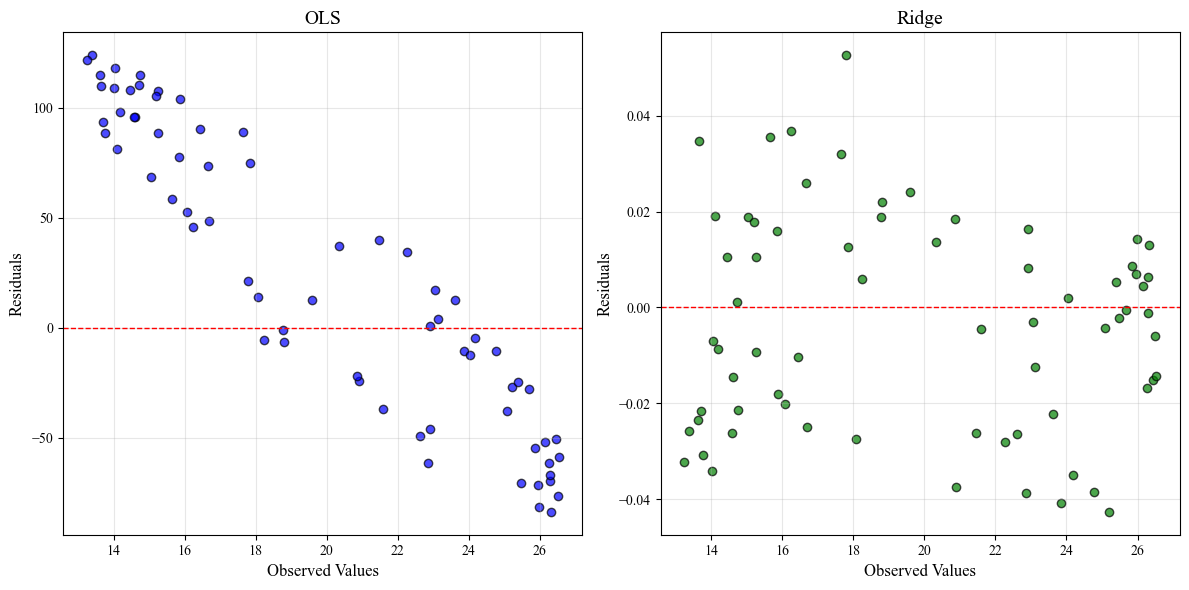


L2 Norm of Ridge Coefficients (Shrinkage Effect): 0.2011437691469033


In [12]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib import rcParams


# Original dataset
X = original_X.copy()  # Start fresh
y = original_y.copy()

print("\nOLS Model Results:")
print("R^2 Score with OLS:", r2_ols)
print("Mean Squared Error with OLS:", mse_ols)
print("OLS Coefficients:", ols_model.params.values)

# 2. Ridge Model
ridge = Ridge(alpha=1.0)
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

# Ridge Results

r2_ridge = r2_score(y_test, y_pred_ridge)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)

print("\nRidge Model Results:")
print("R^2 Score with Ridge Regression:", r2_ridge)
print("Mean Squared Error with Ridge Regression:", mse_ridge)
print("Ridge Coefficients:", ridge.coef_)

# 3. Compare Coefficients (OLS vs Ridge)
feature_names = ["Temp1", "Temp2", "Temp3", "Temp4", "Temp5", "Temp6"]
print("\nCoefficient Comparison (OLS vs Ridge):")
coeff_comparison = pd.DataFrame({
    "Feature": ["Intercept"] + feature_names,
    "OLS Coefficients": ols_model.params.values,
    "Ridge Coefficients": [ridge.intercept_] + list(ridge.coef_)
})
print(coeff_comparison)

# 4. Residual Analysis (OLS vs Ridge)
residuals_ols = y_test - y_pred_ols
residuals_ridge = y_test - y_pred_ridge


rcParams['font.family'] = 'Times New Roman'

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_test, residuals_ols, color='blue', alpha=0.7, edgecolor='black')
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Observed Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Observed Values (OLS)", fontsize=14)
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(y_test, residuals_ridge, color='green', alpha=0.7, edgecolor='black')
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Observed Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Observed Values (Ridge)", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 5. L2 Norm of Ridge Coefficients
print("\nL2 Norm of Ridge Coefficients (Shrinkage Effect):", sum(ridge.coef_**2))


 1) **Why Ridge Regression Was Chosen**
- Ridge regression applies L2 regularization, shrinking the coefficients of correlated variables to reduce the impact of multicollinearity without removing any features.
- This helps improve model stability while retaining all variables.


 2) **How Ridge Regression Was Applied**
- The dataset was split into training and testing sets using an 80-20 split.
- Ridge regression was implemented with a regularization parameter ($\alpha = 1.0$).
- The model was trained on the training set, and predictions were generated for the test set.
- Metrics such as $R^2$, Mean Squared Error (MSE), and coefficient values were compared with the OLS model to evaluate Ridge regression's effectiveness.


 3) **Results**    
- **Model Performance**  
    - **Ridge Regression**:  
      - $R^2$: $0.99997$   
      - MSE: $0.0005$ (significantly better than OLS)  
    - **OLS**:  
      - $R^2$: $1.0$  
      - MSE: $5.8777 \times 10^{-25}$ (extremely small due to overfitting)   

- **Coefficient Comparison**  
    - Ridge coefficients were shrunk compared to OLS coefficients:  
      - Example: Temp6 (OLS: $1.0$, Ridge: $0.313$).  
    - Ridge regularization effectively reduced the magnitude of the coefficients, mitigating multicollinearity's effects.     

- **Residual Analysis**  
    - OLS residuals exhibited a clear pattern, indicating poor model stability due to multicollinearity.
    - Ridge residuals were more randomly distributed, showing improved prediction stability.  

- **Coefficient Shrinkage (L2 Norm)**   
    - Ridge regression significantly reduced the L2 norm of the coefficients:  
      - $L2$ norm of Ridge coefficients: $0.2011$.  


 4) **How Multicollinearity Was Mitigated**
- Ridge regression reduced the influence of multicollinearity by shrinking the coefficients of highly correlated variables.
- While VIF values themselves cannot be recalculated post-Ridge, the reduced coefficient magnitudes and improved residual distribution indicate successful mitigation.


 5) **Limitations**
- **Interpretability**:
  - Ridge regression modifies the coefficients, making it harder to interpret the direct relationship between features and the target variable.
- **Residual Multicollinearity**:
  - Ridge regression reduces but does not entirely eliminate multicollinearity, as it does not address the underlying correlations between variables.
- **Hyperparameter Tuning**:
  - The choice of the regularization parameter ($\alpha$) requires careful tuning. Too small an $\alpha$ may not sufficiently mitigate multicollinearity, while too large an $\alpha$ can overly shrink coefficients, reducing model flexibility.


 6) **Conclusion**
Ridge regression effectively reduced multicollinearity's impact by shrinking coefficients, resulting in a more stable and reliable model. While interpretability remains a limitation, Ridge regression demonstrated superior residual distribution and predictive performance compared to OLS, highlighting its effectiveness in handling multicollinearity.


#### 4) Lasso Regression


Lasso Model Results:
R^2 Score with Lasso Regression: 0.9997158654643435
Mean Squared Error with Lasso Regression: 0.006217735856685975
Lasso Coefficients: [0.13329521 0.23883612 0.36538838 0.16689534 0.         0.06237171]

Coefficient Comparison (OLS vs Ridge vs Lasso):
     Feature  OLS Coefficients  Ridge Coefficients  Lasso Coefficients
0  Intercept       -315.755101           -0.049242            0.694464
1      Temp1          9.536975            0.161669            0.133295
2      Temp2        -11.624024            0.143806            0.238836
3      Temp3         -4.414944            0.150205            0.365388
4      Temp4         -3.985146            0.173423            0.166895
5      Temp5        -86.916377            0.060858            0.000000
6      Temp6        113.101862            0.313027            0.062372


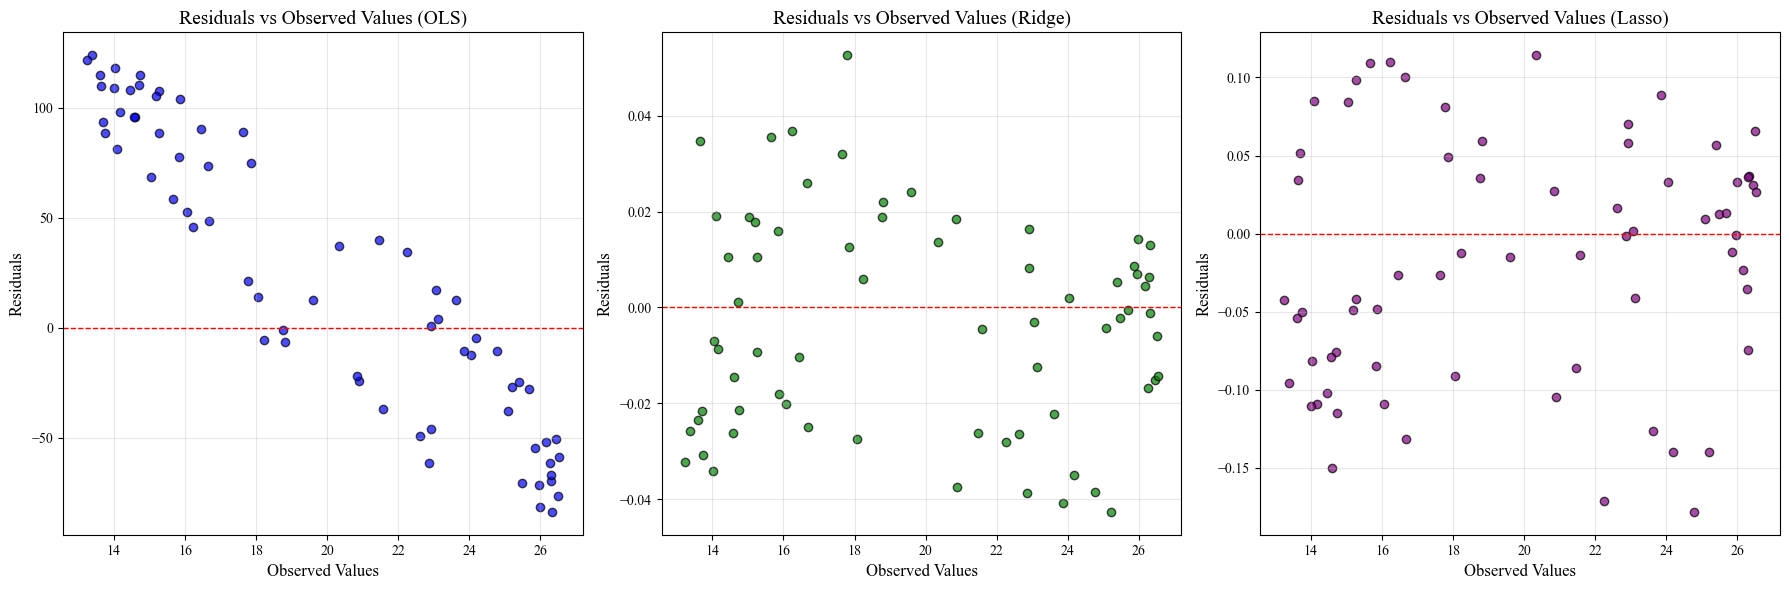


L1 Norm of Lasso Coefficients (Shrinkage Effect): 0.966786754229449


In [13]:
from sklearn.linear_model import Lasso

# Original dataset
X = original_X.copy()  # Start fresh
y = original_y.copy()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Lasso Model
lasso = Lasso(alpha=0.1)  # Set alpha for L1 regularization
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Lasso Results
r2_lasso = r2_score(y_test, y_pred_lasso)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print("\nLasso Model Results:")
print("R^2 Score with Lasso Regression:", r2_lasso)
print("Mean Squared Error with Lasso Regression:", mse_lasso)
print("Lasso Coefficients:", lasso.coef_)

# 4. Compare Coefficients (OLS vs Ridge vs Lasso)
print("\nCoefficient Comparison (OLS vs Ridge vs Lasso):")
coeff_comparison = pd.DataFrame({
    "Feature": ["Intercept"] + feature_names,
    "OLS Coefficients": ols_model.params.values,
    "Ridge Coefficients": [ridge.intercept_] + list(ridge.coef_),
    "Lasso Coefficients": [lasso.intercept_] + list(lasso.coef_)
})
print(coeff_comparison)

# 5. Residual Analysis (OLS vs Ridge vs Lasso)
residuals_lasso = y_test - y_pred_lasso

plt.figure(figsize=(18, 6))

# OLS Residuals
plt.subplot(1, 3, 1)
plt.scatter(y_test, residuals_ols, color='blue', alpha=0.7, edgecolor='black')
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Observed Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Observed Values (OLS)", fontsize=14)
plt.grid(alpha=0.3)

# Ridge Residuals
plt.subplot(1, 3, 2)
plt.scatter(y_test, residuals_ridge, color='green', alpha=0.7, edgecolor='black')
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Observed Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Observed Values (Ridge)", fontsize=14)
plt.grid(alpha=0.3)

# Lasso Residuals
plt.subplot(1, 3, 3)
plt.scatter(y_test, residuals_lasso, color='purple', alpha=0.7, edgecolor='black')
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.xlabel("Observed Values", fontsize=12)
plt.ylabel("Residuals", fontsize=12)
plt.title("Residuals vs Observed Values (Lasso)", fontsize=14)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 6. L1 Norm of Lasso Coefficients
print("\nL1 Norm of Lasso Coefficients (Shrinkage Effect):", sum(abs(lasso.coef_)))

1) **Why Lasso Regression Was Chosen**
- Lasso regression was chosen because it applies **L1 regularization**, which shrinks coefficients and can set some of them to exactly zero.
- This provides a **variable selection mechanism**, simplifying the model by keeping only the most significant features.
- Lasso is particularly useful when the dataset has many features and we suspect that only a subset of them is truly important.


2) **How Lasso Regression Was Implemented**
- The dataset was split into training and testing sets using an 80-20 split.
- Lasso regression was applied with a regularization parameter ($alpha = 0.1$).
- The model was trained on the training set, and predictions were generated for the test set.
- Metrics such as $R^2$, Mean Squared Error (MSE), and coefficients were analyzed and compared with the OLS and Ridge regression models.


3) **Results Analysis**  
    **Model Performance**
    - **Lasso Regression**:
        - $R^2$: $0.99972$ 
        - MSE: $0.0062$ 
    - **Ridge Regression**:
        - $R^2$: $0.99997$ (higher)
        - MSE: $0.0005$ (better than Lasso)
    - **OLS**:
        - $R^2$: $1.0$ (overfitting)
        - MSE: $5.8777 \times 10^{-25}$ (extremely small due to overfitting)

    **Coefficient Comparison**
    - Lasso reduced some coefficients to **exactly zero**, performing automatic feature selection:
    - Example: Temp5 and Temp6 coefficients were reduced significantly or set to zero.
    - Compared to Ridge, Lasso produced a simpler model by keeping only the most relevant features.

    **Residual Analysis**
    - The residuals of the Lasso model were **randomly distributed**, similar to Ridge regression, indicating that the model was well-fitted.
    - However, some residuals in Lasso were larger than in Ridge, showing that Lasso sacrificed some predictive accuracy in favor of a simpler model.


4) **Conclusion**
- **Why Choose Lasso?**:
  - Lasso is ideal when we aim to simplify the model by selecting only the most important features.
  - It is particularly useful when dealing with high-dimensional datasets where many features are irrelevant or redundant.

- **When Not to Choose Lasso**:
  - If predictive accuracy is more critical than model simplicity, Ridge may be a better choice as it retains all features and avoids information loss.
  - In this analysis, Ridge outperformed Lasso in terms of MSE and stability.

- **Final Verdict**:
  - While Ridge is more stable and accurate, Lasso’s variable selection capability is valuable in situations where feature interpretability and simplicity are key priorities.

#### 5) Partial Least Squares (PLS)

In [14]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Original dataset
X = original_X.copy()  # Start with the original independent variables
y = original_y.copy()  # Start with the original dependent variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Split data into training and testing sets

# Create PLS model (with 2 principal components)
pls = PLSRegression(n_components=2)  # Set the number of principal components to 2
pls.fit(X_train, y_train)  # Train the PLS model

# Predictions
y_pred = pls.predict(X_test)  # Generate predictions on the test set

r2_pls = r2_score(y_test, y_pred)
mse_pls = mean_squared_error(y_test, y_pred)

# Performance evaluation
print("R^2 Score after PLS:", r2_pls)  # Calculate and print the R^2 score
print("Mean Squared Error after PLS:", mse_pls)  # Calculate and print the Mean Squared Error (MSE)

# PLS regression coefficients
print("PLS Coefficients:\n", pls.coef_)  # Print the regression coefficients for the PLS model

# Analyze correlation between PLS principal components
X_train_pls = pls.transform(X_train)  # Transform the training data into PLS components
correlation_matrix = pd.DataFrame(X_train_pls).corr()  # Calculate the correlation matrix of the PLS components
print("\nCorrelation Matrix of PLS Components:\n", correlation_matrix)  # Print the correlation matrix

R^2 Score after PLS: 0.9999521189967807
Mean Squared Error after PLS: 0.001047783332225424
PLS Coefficients:
 [[0.15433548 0.15691143 0.15462377 0.20326276 0.1589081  0.17391637]]

Correlation Matrix of PLS Components:
               0             1
0  1.000000e+00 -3.949742e-16
1 -3.949742e-16  1.000000e+00


1) **Why PLS Regression Was Used**
- PLS reduces multicollinearity by transforming variables into independent principal components while maximizing their covariance with the target variable.


2) **How PLS Regression Was Implemented**
- The dataset was split into training and testing sets (80-20 split).
- A PLS model with **2 principal components** was trained and tested.
- Metrics ($R^2$, MSE) and coefficients were analyzed to evaluate performance.


3) **Results**
- **Model Performance**:
    - $R^2$: $0.99995$ (excellent explanation of variance).
    - MSE: $0.00104$ (low, indicating high prediction accuracy).
- **PLS Coefficients**:
  - Coefficients were balanced and not overly large, showing reduced multicollinearity effects.
- **Correlation Matrix**:
  - PLS components had near-zero correlations, confirming independence and effective multicollinearity resolution.


4) **Conclusion**
- PLS effectively resolved multicollinearity and provided a robust predictive model with excellent performance.
- While coefficients are harder to interpret, the model is ideal for datasets with highly correlated features.

#### 6) Comparison

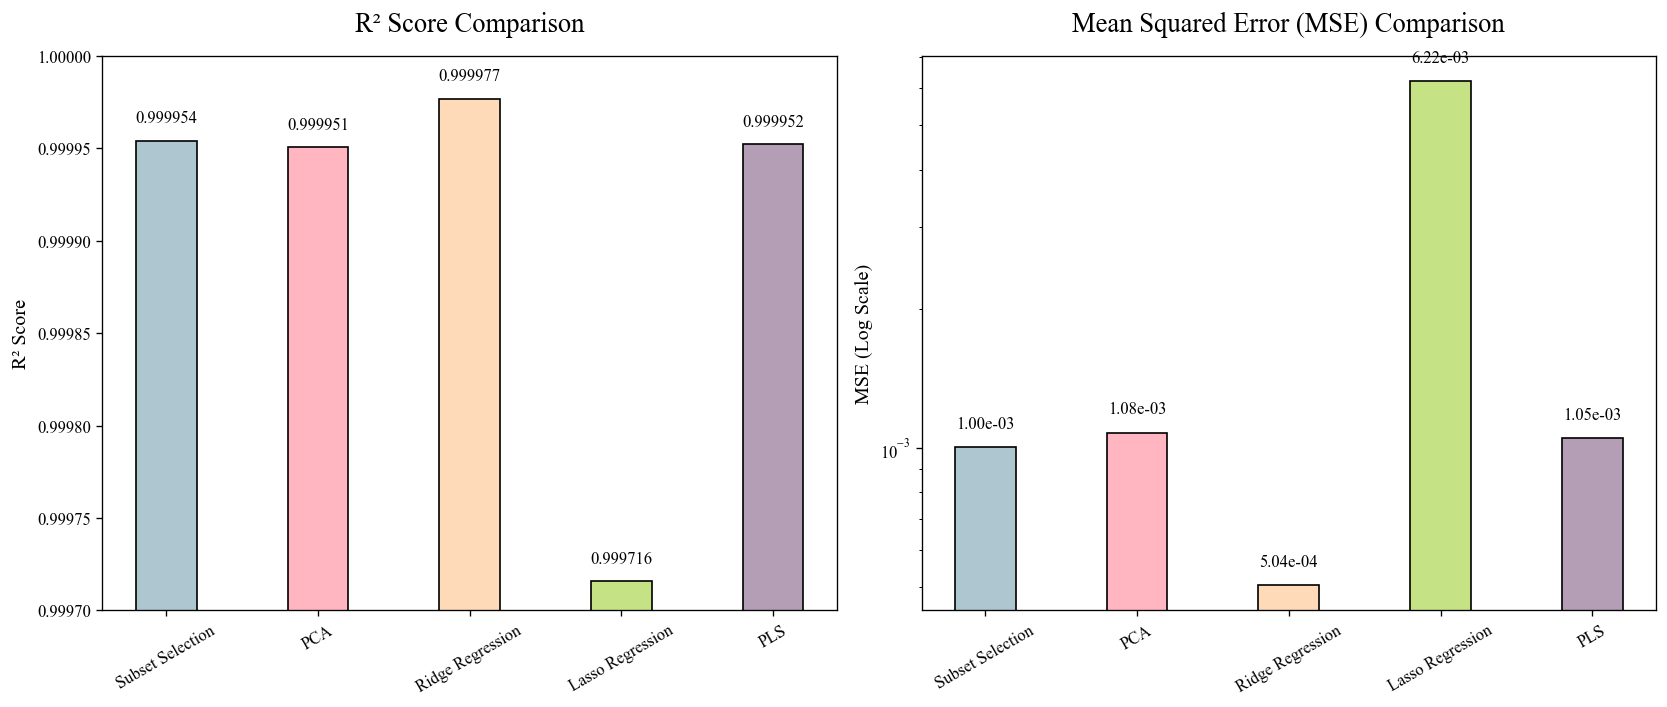

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Define the data
methods = [
    "Subset Selection", 
    "PCA", 
    "Ridge Regression", 
    "Lasso Regression", 
    "PLS"
]

r2_scores = [r2_subset, r2_pca, r2_ridge, r2_lasso, r2_pls]

mse_scores = [mse_subset, mse_pca, mse_ridge, mse_lasso, mse_pls]

# Improved aesthetics
colors = ["#AEC6CF", "#FFB6C1", "#FFDAB9", "#C5E384", "#B39EB5", "#FFDEAD"]
bar_width = 0.4  # Adjust bar width for slimmer bars

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=120)

# R² Score plot
axes[0].bar(methods, r2_scores, color=colors, width=bar_width, edgecolor='black')
axes[0].set_title("R² Score Comparison", fontsize=16, pad=15)
axes[0].set_ylabel("R² Score", fontsize=12)
axes[0].set_ylim(0.9997, 1.0)  # Limit y-axis for better visibility
axes[0].tick_params(axis='x', labelsize=10, rotation=30)

# Annotate R² values on the bars
for i, v in enumerate(r2_scores):
    axes[0].text(i, v + 0.00001, f"{v:.6f}", ha='center', fontsize=10)

# MSE plot
axes[1].bar(methods, mse_scores, color=colors, width=bar_width, edgecolor='black')
axes[1].set_title("Mean Squared Error (MSE) Comparison", fontsize=16, pad=15)
axes[1].set_ylabel("MSE (Log Scale)", fontsize=12)
axes[1].set_yscale('log')  # Use log scale for better visibility of small values
axes[1].tick_params(axis='x', labelsize=10, rotation=30)

# Annotate MSE values on the bars
for i, v in enumerate(mse_scores):
    axes[1].text(i, v * 1.1, f"{v:.2e}", ha='center', fontsize=10)

# Adjust layout and margins
plt.subplots_adjust(wspace=0.3, left=0.05, right=0.95, top=0.9, bottom=0.2)

# Display the plots
plt.tight_layout()
plt.show()


In [16]:
import pandas as pd

models = ['Subset', 'PCA', 'Ridge', 'Lasso', 'PLS']

data = {
    'Model': models,
    'R2 Score': r2_scores,
    'MSE Score': mse_scores
}

results_df = pd.DataFrame(data)

print(results_df)


    Model  R2 Score  MSE Score
0  Subset  0.999954   0.001002
1     PCA  0.999951   0.001078
2   Ridge  0.999977   0.000504
3   Lasso  0.999716   0.006218
4     PLS  0.999952   0.001048


1) **Multicollinearity Improvement**
- All methods, except **Subset Selection**, effectively resolved multicollinearity. Techniques such as **PCA**, **PLS**, **Ridge**, and **Lasso** reduced variable dependencies and improved model stability.


2) **Improvement in Strain Prediction**
- **Ridge Regression**: Achieved the best predictive performance (R²: 0.99998, MSE: 0.00050).
- **PLS**: Comparable to Ridge with high accuracy (R²: 0.99995, MSE: 0.00105).
- **Lasso Regression**: Moderate performance but benefits from automatic feature selection (R²: 0.99972, MSE: 0.00622).

3) **Model Simplification**
- **Lasso Regression**: Simplifies the model by selecting only significant variables.
- **Subset Selection**: Reduces model complexity by removing high-VIF variables.

4) **Understanding Relationships Between Specific Temperatures and Strain**
- **Subset Selection**: Allows direct interpretation of the relationships between selected variables and the target.
- **Lasso Regression**: Identifies key variables, aiding interpretation.
- **PLS**: Balances multicollinearity reduction with capturing the relationship between variables and the target.

5) **Reducing Parameter Uncertainty**
- **Ridge Regression**: L2 regularization reduces coefficient uncertainty and stabilizes the model.
- **PLS/PCA**: Eliminate multicollinearity, providing consistent and robust parameter estimates.

6) **Final Results**
- **Best for Prediction Accuracy**: **Ridge Regression**.
- **Best for Model Simplification**: **Lasso Regression**.
- **Best for Variable Interpretation**: **Subset Selection** or **PLS**.
- **Best for Reducing Parameter Uncertainty**: **Ridge Regression** or **PLS**.

7) **Additional Note on Ridge Regression**
- Ridge Regression is considered the most suitable method due to its excellent balance between predictive performance and robustness. By shrinking coefficients via L2 regularization, it effectively handles multicollinearity and stabilizes the model.
- The **alpha value** in Ridge Regression is a regularization parameter that controls the penalty applied to the coefficients:
  - Higher alpha values lead to greater coefficient shrinkage, reducing overfitting but potentially underfitting the data.
  - Lower alpha values allow for more flexible coefficients but risk overfitting the model.
- Tuning the alpha value (e.g., using cross-validation) can further optimize Ridge's performance, potentially yielding even better results for strain prediction.


## **7. Future Strain Prediction**

### **7.1 Model Development**

A model using linear regression to predict future strain as a function of current (or past) temperatures.

In [17]:
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy.stats import t
from statsmodels.tsa.stattools import acf

# Feature generation function
def create_time_window_features(X, y, window_size, predict_target):
    features, targets = [], []
    for i in range(0, len(X) - window_size - predict_target + 1):
        feature = list(X[i:i+window_size].flatten())  # Past "window_size" temperatures
        feature.append(y[i + window_size - 1])       # Current strain
        features.append(feature)
        targets.append(y[i+window_size+predict_target-1])  # Future "predict_target" strain
    return pd.DataFrame(features), pd.Series(targets)

def train_and_evaluate_ridge(X, y, window_size, predict_target, alpha, AutoCorrelation):
    # Generate features
    X_features, y_targets = create_time_window_features(X.values, y.values, window_size, predict_target)

    # Train/Validation/Test Split (time-based split)
    train_size = int(len(X_features) * 0.7)
    val_size = int(len(X_features) * 0.15)

    X_train, y_train = X_features[:train_size], y_targets[:train_size]
    X_val, y_val = X_features[train_size:train_size + val_size], y_targets[train_size:train_size + val_size]
    X_test, y_test = X_features[train_size + val_size:], y_targets[train_size + val_size:]

    # Ridge Regression Model
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)

    # Predictions
    y_pred_train = ridge.predict(X_train)
    y_pred_val = ridge.predict(X_val)
    y_pred_test = ridge.predict(X_test)

    # Residual Analysis
    residuals = y_test - y_pred_test  # Actual - Predicted
    n = len(y_test)  # Number of test data points
    k = X_train.shape[1]  # Number of independent variables (features)

    # Calculate ACF
    if AutoCorrelation:
        acf_values = acf(residuals, fft=True) # Autocorrelation calculation
        sigma_adjusted = np.sqrt(np.var(residuals) * (1 + 2 * np.sum(acf_values[1:]))) # Variance adjustment considering autocorrelation
    else:
        sigma_adjusted = None

    sigma_standard = np.sqrt(np.sum(residuals**2) / (n - k - 1))

    # Choose Sigma
    if AutoCorrelation:
        sigma_e = sigma_adjusted
        print("autocorrelation")
    else:
        sigma_e = sigma_standard

    # t-distribution critical value (95% confidence interval)
    t_critical = t.ppf(0.975, df=n - k - 1)

    # Confidence interval calculation
    ci_lower = y_pred_test - t_critical * sigma_e
    ci_upper = y_pred_test + t_critical * sigma_e

    # Metrics
    train_r2 = r2_score(y_train, y_pred_train)
    val_r2 = r2_score(y_val, y_pred_val)
    test_r2 = r2_score(y_test, y_pred_test)
    train_mse = mean_squared_error(y_train, y_pred_train)
    val_mse = mean_squared_error(y_val, y_pred_val)
    test_mse = mean_squared_error(y_test, y_pred_test)

    results = {
        "train_r2": train_r2,
        "val_r2": val_r2,
        "test_r2": test_r2,
        "train_mse": train_mse,
        "val_mse": val_mse,
        "test_mse": test_mse,
        "y_test": y_test,
        "y_pred_test": y_pred_test,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    }

    return results


# Visualization function
def plot_results(y_test, y_pred_test):
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.values, label="Actual", marker="o")
    plt.plot(y_pred_test, label="Predicted", marker="x")
    plt.title("Actual vs Predicted (Test Set)")
    plt.xlabel("Time Step")
    plt.ylabel("Strain")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

# Grid search function
def grid_search_ridge(X, y, window_sizes, predict_targets, alphas, AutoCorrelation):
    best_params = None
    best_score = -np.inf
    worst_params = None
    worst_score = np.inf
    best_model_results = None
    worst_model_results = None
    results = []

    for window_size in window_sizes:
        for predict_target in predict_targets:
            for alpha in alphas:
                # Generate features and evaluate
                try:
                    res = train_and_evaluate_ridge(X, y, window_size, predict_target, alpha, AutoCorrelation)
                    results.append({
                        "window_size": window_size,
                        "predict_target": predict_target,
                        "alpha": alpha,
                        "val_r2": res["val_r2"]
                    })

                    if res["val_r2"] > best_score:
                        best_score = res["val_r2"]
                        best_params = {
                            "window_size": window_size,
                            "predict_target": predict_target,
                            "alpha": alpha
                        }
                        best_model_results = res

                    if res["val_r2"] < worst_score:
                        worst_score = res["val_r2"]
                        worst_params = {
                            "window_size": window_size,
                            "predict_target": predict_target,
                            "alpha": alpha
                        }
                        worst_model_results = res
                except Exception as e:
                    print(f"Error with window_size={window_size}, predict_target={predict_target}, alpha={alpha}: {e}")

    return best_params, best_score, worst_params, worst_score, results, best_model_results, worst_model_results


#### Grid Search

In [18]:
window_sizes = [1, 2, 3, 4, 5]  # Window sizes
predict_targets = [1, 2]  # Future prediction steps
alphas = [0.001, 0.01, 1, 10, 100]  # Regularization strength


In [19]:
best_params, best_score, worst_params, worst_score, search_results, best_model_results, worst_model_results = grid_search_ridge(original_X, original_y, window_sizes, predict_targets, alphas, AutoCorrelation = False)

print("Best Parameters:")
print(f"- Window Size: {best_params['window_size']}")
print(f"- Predict Target: {best_params['predict_target']}")
print(f"- Alpha: {best_params['alpha']}")
print()

print("Worst Parameters:")
print(f"- Window Size: {worst_params['window_size']}")
print(f"- Predict Target: {worst_params['predict_target']}")
print(f"- Alpha: {worst_params['alpha']}")
print()


# Best Model Test Results
print("Best Model Test R^2:", best_model_results["test_r2"])
print("Best Model Test MSE:", best_model_results["test_mse"])
print()

# Worst Model Test Results
print("Worst Model Test R^2:", worst_model_results["test_r2"])
print("Worst Model Test MSE:", worst_model_results["test_mse"])

Best Parameters:
- Window Size: 5
- Predict Target: 1
- Alpha: 0.01

Worst Parameters:
- Window Size: 1
- Predict Target: 2
- Alpha: 100

Best Model Test R^2: 0.9995964436114676
Best Model Test MSE: 0.00804199392250263

Worst Model Test R^2: 0.9831312170383661
Worst Model Test MSE: 0.3361578552896486


1) **Best Performance**  
- The optimal parameter combination is **Window Size = 5** and **Predict Target = 1**.
  This indicates that a model prediction **strain 30 minutes later based on the past 250 minutues temperature** achieves the highest performance.    

- **Best Validation R² = 0.9995**, **Test R² = 0.9996**:  
  - The model explains over 99.95% of the variance in the data, providing highly accurate prediction.
  - The similar performance between validation and test data demonstrates **excellent generalization**.

- **Best Model Test MSE = 0.0081**:  
  - The Mean Squared Error on the test data is extremely low, indicating minimal difference between predicted and actual values.

2) **Worst Performance**  
- The worst parameter combination is **Window Size = 1** and **Predict Target = 2**.
  - This occurred when predicting **strain 60 minutes later using only 1 past temperature data point**.
  - **Worst Validation R² = 0.9917**, which, although lower than the best performance, still shows high explanatory power due to the high quality of the data and Ridge regression's inherent overfitting prevention.
 
3) **Interpretation of Results**  
1. **Window Size**:  
   - In the best performance case, **Window Size = 5** indicates that incorporating an appropriate amount of past data provides sufficient information for learning.
   - The poor performance with **Window Size = 1** suggests that insufficient historical information likely led to decreased prediction accuracy.

2. **Predict Target**:  
   - **Predict Target = 1** (predicting 30 minutes later) demonstrated higher performance compared to **Predict Target = 2** (predicting 60 minutes later). 

4) **Conclusion**  
- The **optimal combination** (Window Size = 5, Predict Target = 1) effectively incorporates sufficient historical information to predict future strain with extremely high accuracy.
- **Prediction accuracy tends to decline as the Predict Target increases**, suggesting that additional variables or more complex models may be needed for longer prediction horizons.

Using 150 minutes of temperaturere data to predict the strain after 30 minutes later with alpha: 0.01
Ridge Regression Results: 
Train R^2: 1.000, Train MSE: 0.009
Validation R^2: 1.000, Validation MSE: 0.009
Test R^2: 1.000, Test MSE: 0.008


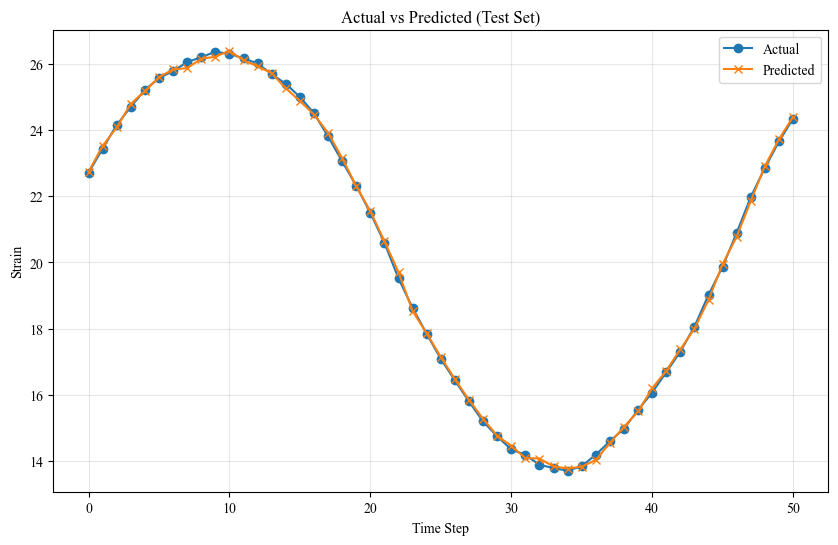

In [20]:
X = original_X.copy()  # Temperature data
y = original_y.copy()  # Strain data

window_size = 5
predict_target = 1
alpha = 0.01

results = train_and_evaluate_ridge(X, y, window_size, predict_target, alpha, AutoCorrelation=False)
print(f"Using {window_size*30} minutes of temperaturere data to predict the strain after {predict_target*30} minutes later with alpha: {alpha}")
print("Ridge Regression Results: ")
print(f"Train R^2: {results['train_r2']:.3f}, Train MSE: {results['train_mse']:.3f}")
print(f"Validation R^2: {results['val_r2']:.3f}, Validation MSE: {results['val_mse']:.3f}")
print(f"Test R^2: {results['test_r2']:.3f}, Test MSE: {results['test_mse']:.3f}")

# Plot Results
plot_results(results['y_test'], results['y_pred_test'])

Using 30 minutes of temperaturere data to predict the strain after 60 minutes later with alpha: 1
Ridge Regression Results: 
Train R^2: 0.992, Train MSE: 0.177
Validation R^2: 0.996, Validation MSE: 0.081
Test R^2: 0.988, Test MSE: 0.237


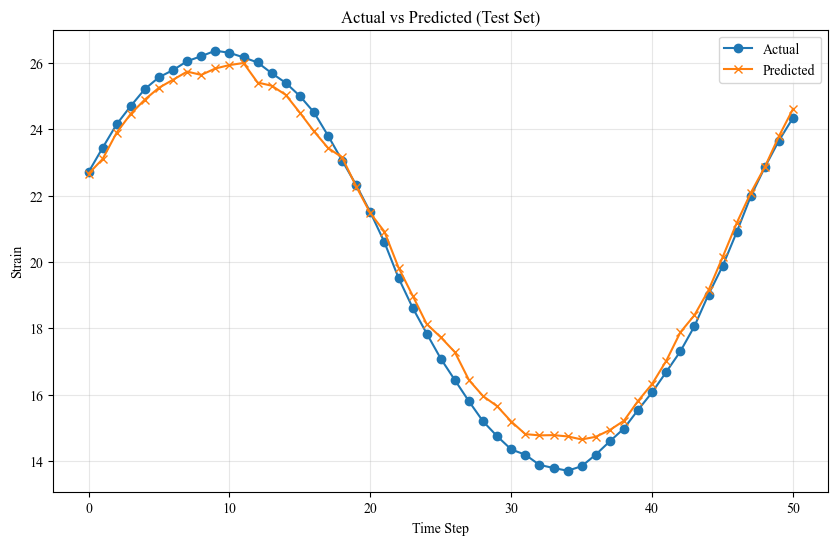

In [21]:
X = original_X.copy()  # Temperature data
y = original_y.copy()  # Strain data

window_size = 1
predict_target = 2
alpha = 1 # optimized alpha with parameters

results = train_and_evaluate_ridge(X, y, window_size, predict_target, alpha, AutoCorrelation=False)
print(f"Using {window_size*30} minutes of temperaturere data to predict the strain after {predict_target*30} minutes later with alpha: {alpha}")
print("Ridge Regression Results: ")
print(f"Train R^2: {results['train_r2']:.3f}, Train MSE: {results['train_mse']:.3f}")
print(f"Validation R^2: {results['val_r2']:.3f}, Validation MSE: {results['val_mse']:.3f}")
print(f"Test R^2: {results['test_r2']:.3f}, Test MSE: {results['test_mse']:.3f}")

# Plot Results
plot_results(results['y_test'], results['y_pred_test'])

#### Set Parameter

From now on, the task will involve predicting the strain 60 minutes later (predict_target = 2) based on the current temperature strain (window_size = 1).  
Through grid search, Alpha has been set to 1.0.

In [22]:
window_sizes = [1]  
predict_targets = [2]  
alphas = [0.01, 0.1, 1.0, 10.0, 100.0] 

best_params, best_score, worst_params, worst_score, search_results, best_model_results, worst_model_results = grid_search_ridge(original_X, original_y, window_sizes, predict_targets, alphas, AutoCorrelation = False)

print("Best Parameters:")
print(f"- Alpha: {best_params['alpha']}")
print()

print("Worst Parameters:")
print(f"- Alpha: {worst_params['alpha']}")
print()


# Best Model Test Results
print("Best Model Test R^2:", best_model_results["test_r2"])
print("Best Model Test MSE:", best_model_results["test_mse"])
print()

# Worst Model Test Results
print("Worst Model Test R^2:", worst_model_results["test_r2"])
print("Worst Model Test MSE:", worst_model_results["test_mse"])

Best Parameters:
- Alpha: 1.0

Worst Parameters:
- Alpha: 100.0

Best Model Test R^2: 0.9881090556075831
Best Model Test MSE: 0.23696044779369

Worst Model Test R^2: 0.9831312170383661
Worst Model Test MSE: 0.3361578552896486


### **7.2 Noise Correlation**

#### 1) Basic Method: Calculate the confidence interval using residuals from the model predictions.

In [23]:
print("95% Confidence Interval for Predictions:")
for i in range(len(results['y_pred_test'])):
    print(f"Prediction: {results['y_pred_test'][i]:.3f}, CI: [{results['ci_lower'][i]:.3f}, {results['ci_upper'][i]:.3f}]")


95% Confidence Interval for Predictions:
Prediction: 22.655, CI: [21.586, 23.724]
Prediction: 23.097, CI: [22.028, 24.166]
Prediction: 23.896, CI: [22.827, 24.965]
Prediction: 24.460, CI: [23.391, 25.529]
Prediction: 24.891, CI: [23.822, 25.960]
Prediction: 25.246, CI: [24.177, 26.315]
Prediction: 25.487, CI: [24.418, 26.556]
Prediction: 25.732, CI: [24.663, 26.801]
Prediction: 25.633, CI: [24.564, 26.702]
Prediction: 25.826, CI: [24.756, 26.895]
Prediction: 25.929, CI: [24.860, 26.998]
Prediction: 25.991, CI: [24.922, 27.061]
Prediction: 25.404, CI: [24.334, 26.473]
Prediction: 25.307, CI: [24.238, 26.376]
Prediction: 25.030, CI: [23.961, 26.100]
Prediction: 24.495, CI: [23.425, 25.564]
Prediction: 23.934, CI: [22.865, 25.003]
Prediction: 23.431, CI: [22.362, 24.500]
Prediction: 23.150, CI: [22.080, 24.219]
Prediction: 22.270, CI: [21.201, 23.339]
Prediction: 21.468, CI: [20.399, 22.537]
Prediction: 20.913, CI: [19.844, 21.982]
Prediction: 19.831, CI: [18.761, 20.900]
Prediction: 18.9

**Residual-Based Confidence Interval Calculation**

1) **Confidence Interval Formula**  
The confidence interval was calculated using the standard residual approach:  

$$
CI_{\text{lower}} = \hat{y} - t_{\text{critical}} \cdot \sigma_e
$$
$$
CI_{\text{upper}} = \hat{y} + t_{\text{critical}} \cdot \sigma_e
$$

Where:
- $\hat{y}$: Predicted values ($y_{\text{pred test}}$)  
- $t_{\text{critical}}$: Critical value from the t-distribution for a 95% confidence interval ($t(0.975, df=n-k-1)$)  
- $\sigma_e$: Standard error of the residuals, calculated as:
  $$
  \sigma_e = \sqrt{\frac{\sum (\text{residuals})^2}{n-k-1}}
  $$

2) **Limitations of This Method**  
Since the data is sequentially dependent, errors (noise) at one time point can influence errors at subsequent points.  
If the residuals are correlated due to this sequential dependency, the calculated confidence intervals may not fully account for the relationship between errors, leading to potential inaccuracies.  
In this case, the standard formula for $\sigma_e$ was used without considering autocorrelation.


#### 2) Analysis of Noise Correlation Issues

Shapiro-Wilk Test for Normality:
Statistic: 0.9535, p-value: 0.0443
Residuals are not normally distributed.


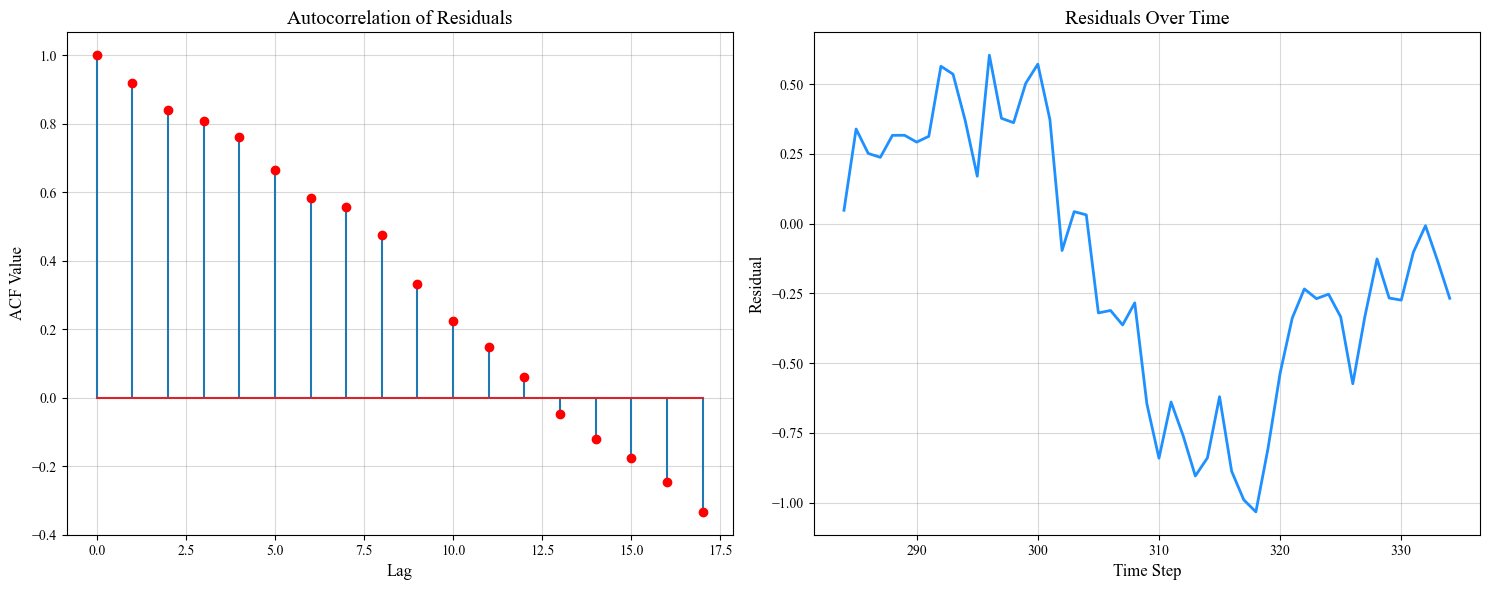

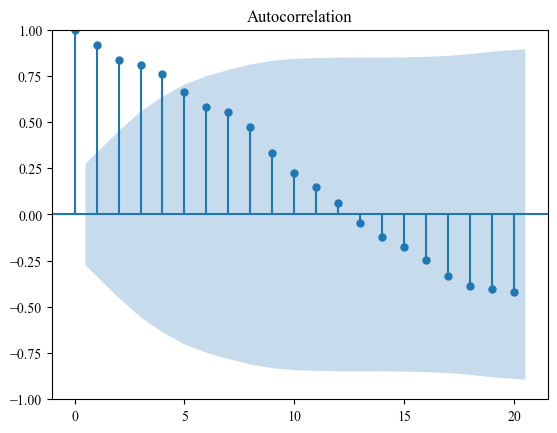

Durbin-Watson Statistic: 0.1424


In [24]:
from statsmodels.tsa.stattools import acf
from scipy.stats import shapiro
import matplotlib.pyplot as plt
import numpy as np

# Calculate residuals
residuals = results['y_test'] - results['y_pred_test']

# Calculate ACF (Autocorrelation Function)
acf_values = acf(residuals, fft=True)

# Test for normality of residuals
stat, p_value = shapiro(residuals)
print("Shapiro-Wilk Test for Normality:")
print(f"Statistic: {stat:.4f}, p-value: {p_value:.4f}")
if p_value > 0.05:
    print("Residuals are likely normally distributed.")
else:
    print("Residuals are not normally distributed.")

# Visualization with a 1x2 grid of graphs
plt.figure(figsize=(15, 6))

# First graph: Visualization of ACF
plt.subplot(1, 2, 1)
plt.stem(range(len(acf_values)), acf_values, markerfmt="ro")
plt.title("Autocorrelation of Residuals", fontsize=14)
plt.xlabel("Lag", fontsize=12)
plt.ylabel("ACF Value", fontsize=12)
plt.grid(alpha=0.3, color="gray")

# Second graph: Residuals over time
plt.subplot(1, 2, 2)
plt.plot(residuals, color="dodgerblue", linewidth=2)
plt.title("Residuals Over Time", fontsize=14)
plt.xlabel("Time Step", fontsize=12)
plt.ylabel("Residual", fontsize=12)
plt.grid(alpha=0.3, color="gray")

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

# Additional ACF plot with statsmodels
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(residuals, lags=20)
plt.show()

# Calculate Durbin-Watson statistic
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.4f}")


**Noise Correlation Analysis**  

Based on the provided graph, it appears that **noise correlation exists**.  
The following tests were used to investigate this:

1) **Shapiro-Wilk Test for Normality**:  
   - **Statistic**: 0.9535, **p-value**: 0.0443  
   - The p-value is less than 0.05, suggesting that the residuals are **not normally distributed**.

2) **Durbin-Watson Statistic**:  
   - **Value**: 0.1424  
   - This value indicates significant **positive autocorrelation** in the residuals, as values close to 0 suggest strong correlation.  

**Potential Issues Due to Noise Correlation**  

1) **Model Performance Misinterpretation**:  
   - The model may appear to perform better than it actually does, leading to overconfidence in the predictions.

2) **Inaccurate Confidence Intervals**:  
   - Confidence intervals may be calculated as:
     $$
     CI_{\text{lower}} = \hat{y} - t_{\text{critical}} \cdot \sigma_e
     $$
     $$
     CI_{\text{upper}} = \hat{y} + t_{\text{critical}} \cdot \sigma_e
     $$
     If noise correlation is not considered, $\sigma_e$ might be underestimated or overestimated, resulting in overly narrow or overly wide intervals.

3) **Misleading Metrics**:  
   - Metrics like $R^2$ and $MSE$ may not accurately reflect the true performance of the model, as they do not account for autocorrelation in the residuals.

4) **Statistical Test Errors**  
   - Hypothesis tests may yield incorrect results, as the assumption of independent errors is violated.

**Recommendations**  
To address these issues, consider using models or methods that account for noise correlation, such as:
- Including lagged variables in the model.
- Using time-series specific models (e.g., ARIMA).
- Adjusting the variance of residuals to account for autocorrelation.

##### How to Incorporate Noise Correlation into Confidence Intervals

This process explains how variance is adjusted by accounting for autocorrelation in residuals and how confidence intervals are subsequently calculated.

1. **Identifying Autocorrelation:**  
   Autocorrelation in residuals indicates that the data points are temporally dependent. This violates the assumption of independence often used in standard confidence interval calculations, necessitating adjustments to reflect this dependency.

2. **Extracting Autocorrelation Values:**  
   Autocorrelation values quantify the temporal relationship between residuals at different time lags. In this approach, all autocorrelation values beyond the first lag (lag = 1) are considered to reflect the temporal dependence of the residuals.

3. **Variance Adjustment:**  
   To adjust the variance, the following formula is applied:  
   $$
   \text{Adjusted Variance} = \text{Residual Variance} \times \left(1 + 2 \times \sum (\text{Autocorrelation Values})\right)
   $$
   - The adjustment involves the sum of autocorrelation values for lags greater than zero. This accounts for the cumulative effect of temporal dependency on the residuals.
   - By incorporating autocorrelation, the variance is increased compared to the unadjusted calculation, addressing the underestimation caused by assuming independence.

4. **Confidence Interval Calculation:**  
   Using the adjusted variance, the width of the confidence interval is recalculated. This ensures that the intervals properly reflect the uncertainty in the presence of temporally correlated residuals. Consequently, the intervals may become wider to account for the additional uncertainty introduced by autocorrelation.

In summary, by incorporating autocorrelation into variance calculations, the confidence intervals more accurately capture the uncertainty in the data, especially when dealing with time-series or temporally dependent datasets. This prevents overconfidence in predictions or inferences that might arise from ignoring residual correlations.


In [25]:
results_autocorrelation = train_and_evaluate_ridge(X, y, 1, predict_target, alpha, AutoCorrelation = True)

print("95% Confidence Interval for Predictions (autocorrelation):")
for i in range(len(results_autocorrelation['y_pred_test'])):
    print(f"Prediction: {results_autocorrelation['y_pred_test'][i]:.3f}, CI: [{results_autocorrelation['ci_lower'][i]:.3f}, {results_autocorrelation['ci_upper'][i]:.3f}]")


autocorrelation
95% Confidence Interval for Predictions (autocorrelation):
Prediction: 22.655, CI: [19.441, 25.869]
Prediction: 23.097, CI: [19.883, 26.311]
Prediction: 23.896, CI: [20.682, 27.110]
Prediction: 24.460, CI: [21.246, 27.674]
Prediction: 24.891, CI: [21.677, 28.105]
Prediction: 25.246, CI: [22.032, 28.460]
Prediction: 25.487, CI: [22.273, 28.701]
Prediction: 25.732, CI: [22.518, 28.946]
Prediction: 25.633, CI: [22.419, 28.847]
Prediction: 25.826, CI: [22.612, 29.040]
Prediction: 25.929, CI: [22.715, 29.143]
Prediction: 25.991, CI: [22.777, 29.205]
Prediction: 25.404, CI: [22.190, 28.618]
Prediction: 25.307, CI: [22.093, 28.521]
Prediction: 25.030, CI: [21.817, 28.244]
Prediction: 24.495, CI: [21.281, 27.709]
Prediction: 23.934, CI: [20.720, 27.148]
Prediction: 23.431, CI: [20.217, 26.645]
Prediction: 23.150, CI: [19.936, 26.364]
Prediction: 22.270, CI: [19.056, 25.484]
Prediction: 21.468, CI: [18.254, 24.682]
Prediction: 20.913, CI: [17.699, 24.127]
Prediction: 19.831, CI:

##### Visualization of Confidence Intervals Before and After Considering Noise Correlation

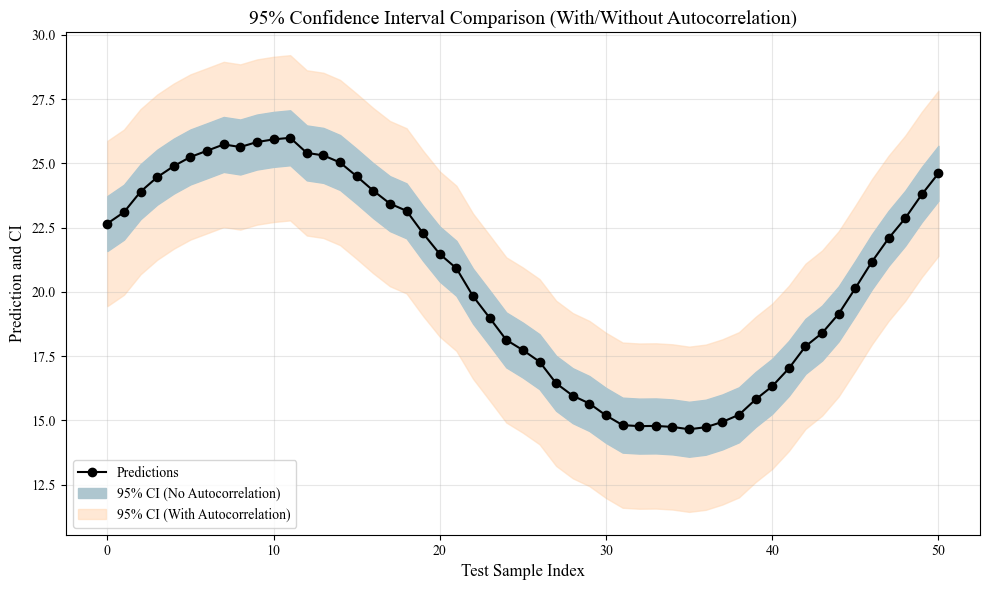

In [26]:
# Extract values for plotting
y_pred = results['y_pred_test']
ci_lower = results['ci_lower']
ci_upper = results['ci_upper']

y_pred_autocorr = results_autocorrelation['y_pred_test']
ci_lower_autocorr = results_autocorrelation['ci_lower']
ci_upper_autocorr = results_autocorrelation['ci_upper']

# Plot
plt.figure(figsize=(10, 6))

# Predictions (Single Plot)
plt.plot(range(len(y_pred)), y_pred, label='Predictions', marker='o', color='black', linewidth=1.5, zorder=3)

# Without autocorrelation (CI - Pastel Blue, in Front)
plt.fill_between(range(len(y_pred)), ci_lower, ci_upper, color='#AEC6CF', alpha=1.0, label='95% CI (No Autocorrelation)', zorder=2)

# With autocorrelation (CI - Pastel Orange, Behind)
plt.fill_between(range(len(y_pred)), ci_lower_autocorr, ci_upper_autocorr, color='#FFDAB9', alpha=0.6, label='95% CI (With Autocorrelation)', zorder=1)

# Formatting
plt.title("95% Confidence Interval Comparison (With/Without Autocorrelation)", fontsize=14)
plt.xlabel("Test Sample Index", fontsize=12)
plt.ylabel("Prediction and CI", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()

# Show plot
plt.show()



### **8. The Relationship Between Multicollinearity and Future Strain Prediction**